## Finding fast growing firms 2025

In [1]:
# Import necessary libraries
import os
import datetime
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.smoothers_lowess import lowess

import warnings
warnings.filterwarnings('ignore')

## Data Preparation 

In [2]:
# Load the dataset
df = pd.read_csv("data/cs_bisnode_panel.csv")

In [3]:
# Select data from years 2010 to 2015
df = df[(df.year >= 2010) & (df.year <= 2015)].copy()
df.shape


(167606, 48)

In [4]:
# Display the number of missing values in each column
df.isna().sum()

comp_id                      0
begin                        0
end                          0
COGS                    158556
amort                     4117
curr_assets                 57
curr_liab                   57
extra_exp                 3751
extra_inc                 3751
extra_profit_loss         3755
finished_prod           158855
fixed_assets                57
inc_bef_tax               3742
intang_assets               57
inventories                 57
liq_assets                  57
material_exp              4117
net_dom_sales           158556
net_exp_sales           158556
personnel_exp             4117
profit_loss_year            67
sales                     3742
share_eq                    57
subscribed_cap              57
tang_assets                 57
wages                   158707
D                       167606
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             18409
exit_yea

In [5]:
# Drop variables with many NAs
df = df.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'])

In [6]:
# Create full firm-year grid
firms = df.comp_id.unique()
years = np.arange(2010, 2016)

panel_grid = pd.MultiIndex.from_product(
    [firms, years],
    names=["comp_id", "year"]
).to_frame(index=False)

df = panel_grid.merge(df, on=["comp_id", "year"], how="left")
df.shape


(236250, 43)

In [7]:
# Display the first few rows of the dataframe
df.head()

,comp_id,year,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2010,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
1,1001034.0,2011,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
2,1001034.0,2012,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
3,1001034.0,2013,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN
4,1001034.0,2014,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN


In [8]:
# Check for negative values in the specified columns and set them to NaN
rawvars = [
    "curr_assets", "curr_liab", "fixed_assets", "intang_assets",
    "inventories", "liq_assets", "sales",
    "profit_loss_year", "inc_bef_tax",
    "material_exp", "personnel_exp",
    "share_eq", "subscribed_cap", "tang_assets"
]

for v in rawvars:
    df.loc[df[v] < 0, v] = np.nan


In [9]:
# Create new variables for definig firm size & scaling
df["sales_mil"] = df.sales / 1e6
df["sales_mil_log"] = np.log1p(df.sales_mil)
df["total_assets"] = df.curr_assets + df.fixed_assets

In [10]:
# Create new variables for defining growth

# balance sheet ratios
df["liq_assets_bs"] = df.liq_assets / df.total_assets
df["curr_assets_bs"] = df.curr_assets / df.total_assets
df["fixed_assets_bs"] = df.fixed_assets / df.total_assets
df["intang_assets_bs"] = df.intang_assets / df.total_assets
df["share_eq_bs"] = df.share_eq / df.total_assets
df["subscribed_cap_bs"] = df.subscribed_cap / df.total_assets

# profit & loss ratios
df["profit_loss_year_pl"] = df.profit_loss_year / df.sales
df["inc_bef_tax_pl"] = df.inc_bef_tax / df.sales
df["material_exp_pl"] = df.material_exp / df.sales
df["personnel_exp_pl"] = df.personnel_exp / df.sales


In [11]:
# Winsorize the specified variables at the 1st and 99th percentiles
def winsorize(s, p=0.01):
    lo, hi = s.quantile([p, 1-p])
    return s.clip(lo, hi)

ratio_vars = [
    "liq_assets_bs", "curr_assets_bs", "fixed_assets_bs",
    "intang_assets_bs", "share_eq_bs",
    "profit_loss_year_pl", "inc_bef_tax_pl",
    "material_exp_pl", "personnel_exp_pl"
]

for v in ratio_vars:
    df[v] = winsorize(df[v])


In [12]:
# Convert categorical variables to category dtype 
df["ind2_cat"] = df.ind2.astype("category")
df["urban_m"] = df.urban_m.astype("category")
df["region_m"] = df.region_m.astype("category")

In [13]:
# Create new variables for defining CEO characteristics
df["ceo_age"] = df.year - df.birth_year
df.loc[(df.ceo_age < 18) | (df.ceo_age > 90), "ceo_age"] = np.nan
df["female"] = df.female.fillna(0)
df["foreign_management"] = df.foreign.fillna(0)


In [14]:
# Calculate firm age
df['age'] = (df['year'] - df['founded_year']).fillna(0)
df.loc[df['age'] < 0, 'age'] = 0 # Fix negative ages if any

# Define foreign management (binary)
df['foreign_management'] = df['foreign'].fillna(0).apply(lambda x: 1 if x >= 0.5 else 0)
# Gender of CEO (binary)
df['gender_m'] = df['gender'].apply(lambda x: 1 if x == 'male' else 0)

In [15]:
# Save the cleaned and processed dataframe to a new CSV file
df.to_csv("data/bisnode_firms_clean_growth.csv", index=False)

## Target design (2014 vs 2012)

In [16]:
# Baseline year
df_2012 = df[df.year == 2012].copy()

# Future sales
df_2014 = df[df.year == 2014][["comp_id", "sales_mil_log"]].copy()
df_2014 = df_2014.rename(columns={"sales_mil_log": "sales_log_2014"})

df_2012 = df_2012.merge(df_2014, on="comp_id", how="inner")


In [17]:
# Define growth metric
df_2012["sales_growth"] = (
    df_2012.sales_log_2014 - df_2012.sales_mil_log
)

df_2012.sales_growth.describe()


count    23149.000000
mean         0.020512
std          0.143778
min         -2.816229
25%         -0.005946
50%          0.000586
75%          0.023385
max          4.393274
Name: sales_growth, dtype: float64

In [18]:
# Define fast-growing firms as those in the top 25% of growth rates in 2014
q75 = df_2012.sales_growth.quantile(0.75)

df_2012["fast_growth"] = (
    df_2012.sales_growth >= q75
).astype(int)

df_2012.fast_growth.value_counts(normalize=True)


fast_growth
0    0.853003
1    0.146997
Name: proportion, dtype: float64

## Feature engineering decisions

In [19]:
# Organize variables into logical groups to build models of increasing complexity.

# Raw Variables
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]

# Financial Ratios 
fin_ratios = [
    "liq_assets_bs", "curr_assets_bs", "fixed_assets_bs",
    "intang_assets_bs", "share_eq_bs",
    "profit_loss_year_pl", "inc_bef_tax_pl", 
    "material_exp_pl", "personnel_exp_pl"
]

# Log Sales (Size) & Growth Lag 
size_vars = ["sales_mil_log"]

# Firm demographics
demo_vars = ["age", "foreign_management", "gender_m", "nace_main", "ind2_cat", "region_m", "urban_m"]

# Human Resources / CEO (derived from class logic)
hr_vars = ["ceo_age", "ceo_count"]

# All potential predictors before interactions
all_predictors = size_vars + fin_ratios + demo_vars + hr_vars + rawvars

In [20]:
# Imputation with Flags
# For continuous variables, we impute with the median and add a "missing" flag.
vars_to_impute = fin_ratios + ["ceo_age", "labor_avg"]

for col in vars_to_impute:
    if col in df_2012.columns:
        # Create a flag column: 1 if missing, 0 otherwise
        df_2012[f'flag_miss_{col}'] = df_2012[col].isna().astype(int)
        
        # Fill missing values with the median
        median_val = df_2012[col].median()
        df_2012[col] = df_2012[col].fillna(median_val)

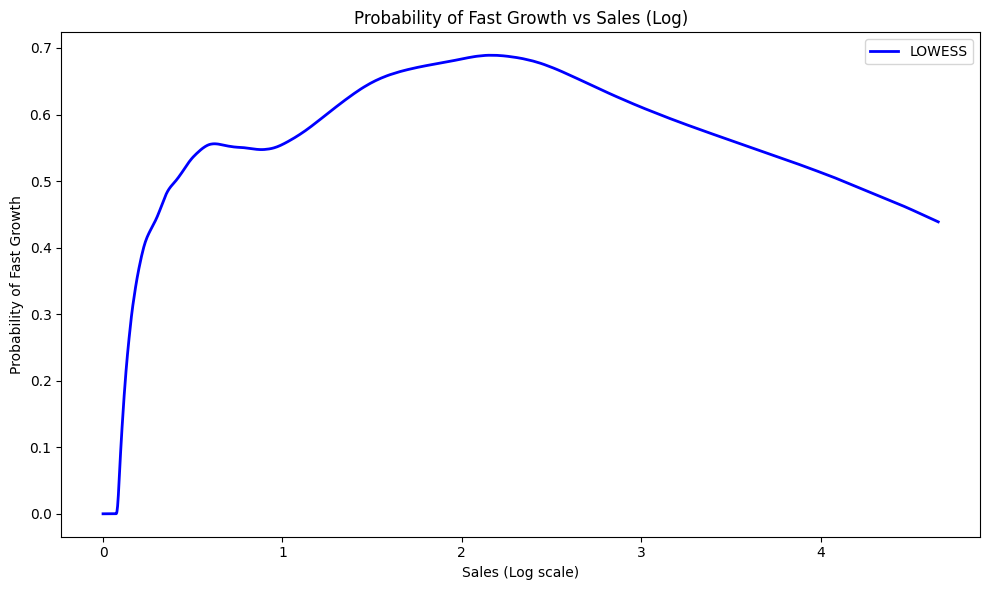

In [21]:
# We check the relationship between sales log and the probability of fast growth using LOWESS smoothing.

var = "sales_mil_log"
fig, ax = plt.subplots(figsize=(10, 6))

# Sample data for faster plotting if dataset is huge
sample_df = df_2012.sample(min(10000, len(df_2012)), random_state=42)

subset = sample_df.dropna(subset=[var, 'fast_growth'])
if len(subset) > 0:
    lowess_result = lowess(subset['fast_growth'], subset[var], frac=0.3)
    sns.lineplot(x=lowess_result[:, 0], y=lowess_result[:, 1], ax=ax, color='blue', linewidth=2, label='LOWESS')
    
    ax.set_title('Probability of Fast Growth vs Sales (Log)')
    ax.set_xlabel('Sales (Log scale)')
    ax.set_ylabel('Probability of Fast Growth')
    ax.legend()

plt.tight_layout()
plt.show()

In [22]:
# Add Squared Terms
df_2012['sales_mil_log_sq'] = df_2012['sales_mil_log'] ** 2
df_2012['age_sq'] = df_2012['age'] ** 2
df_2012['profit_loss_year_pl_sq'] = df_2012['profit_loss_year_pl'] ** 2

# Create Categorical Dummies using Patsy
# Ensure categorical types
df_2012['ind2_cat'] = df_2012['ind2_cat'].astype('category')
df_2012['region_m'] = df_2012['region_m'].astype('category')

# Create dummies
import patsy

# Industry dummies
ind_dummies = patsy.dmatrix("0 + C(ind2_cat)", df_2012, return_type='dataframe')
ind_dummies.columns = [c.replace("C(ind2_cat)", "ind") for c in ind_dummies.columns]

# Region dummies
region_dummies = patsy.dmatrix("0 + C(region_m)", df_2012, return_type='dataframe')
region_dummies.columns = [c.replace("C(region_m)", "region") for c in region_dummies.columns]

# Concatenate back to dataframe
df_2012 = pd.concat([df_2012, ind_dummies, region_dummies], axis=1)

In [ ]:
# Define Variable Sets for Modeling
# X1: Simple Model (Size + Age + location/industry controls)
X1_vars = ["sales_mil_log", "sales_mil_log_sq", "age", "age_sq"] + \
          list(ind_dummies.columns) + list(region_dummies.columns)

# X2: Financial Model (X1 + Financial Ratios)
X2_vars = X1_vars + fin_ratios + ["profit_loss_year_pl_sq"]

# X3: Full Logit Model (X2 + Human Capital + Quality Flags)
# We include the imputation flags here to capture data quality signals.
flag_cols = [c for c in df_2012.columns if "flag_miss" in c]
X3_vars = X2_vars + ["foreign_management", "gender_m", "ceo_age"] + flag_cols

# X4: Random Forest Set (Can handle raw variables and interactions internally)
# For RF, we typically use the raw versions (no squared terms needed), 
# but we keep ratios as they are better predictors than raw absolute numbers.
rf_vars = ["sales_mil", "age", "foreign_management", "gender_m", "ceo_age", "ceo_count"] + \
          fin_ratios + flag_cols + list(ind_dummies.columns) + list(region_dummies.columns)

print(f"N predictors for X1: {len(X1_vars)}")
print(f"N predictors for X3 (Full Logit): {len(X3_vars)}")
print(f"N predictors for RF: {len(rf_vars)}")

N predictors for X1: 74
N predictors for X3 (Full Logit): 98
N predictors for RF: 96
